In [1]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt


In [45]:
# Load the Dataset
def load_data():
    ratings_path = "/content/drive/MyDrive/Deep_Learning_Projects/recommender_system/ml-1m/ml-1m/ratings.dat"
    movies_path = "/content/drive/MyDrive/Deep_Learning_Projects/recommender_system/ml-1m/ml-1m/movies.dat"

    # Load ratings.dat with specified encoding
    ratings = pd.read_csv(ratings_path, sep="::", engine="python",
                          names=["user_id", "movie_id", "rating", "timestamp"], encoding='ISO-8859-1')

    # Load movies.dat with specified encoding
    movies = pd.read_csv(movies_path, sep="::", engine="python",
                         names=["movie_id", "title", "genres"], encoding='ISO-8859-1')

    return ratings, movies


In [46]:
ratings, movies = load_data()
print("Ratings Dataset:\n", ratings.head())
print("\nMovies Dataset:\n", movies.head())


Ratings Dataset:
    user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291

Movies Dataset:
    movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy


In [47]:
# Data Preprocessing
def preprocess_data(ratings):
    user_encoder = LabelEncoder()
    movie_encoder = LabelEncoder()

    # Encode user and movie IDs
    ratings["user_id"] = user_encoder.fit_transform(ratings["user_id"])
    ratings["movie_id"] = movie_encoder.fit_transform(ratings["movie_id"])

    # Split into train, validation, and test sets
    train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)
    val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

    return train_data, val_data, test_data, user_encoder, movie_encoder


In [48]:
# Preprocess Ratings
train_data, val_data, test_data, user_encoder, movie_encoder = preprocess_data(ratings)
print("Train Data Sample:\n", train_data.head())


Train Data Sample:
         user_id  movie_id  rating  timestamp
416292     2506      2821       2  974076680
683230     4086      2633       4  965431652
2434         18       443       3  978146863
688533     4117      2599       4  965804599
472584     2906       759       4  971838472


In [49]:
# Data Visualization
def visualize_data(data):
    plt.figure(figsize=(10, 5))
    data["rating"].value_counts().sort_index().plot(kind="bar", color="skyblue")
    plt.title("Rating Distribution")
    plt.xlabel("Ratings")
    plt.ylabel("Count")
    plt.show()


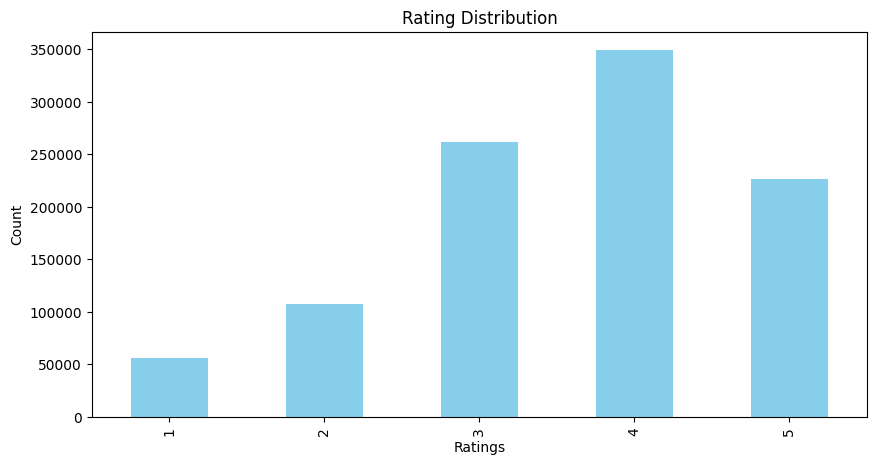

In [50]:
# Visualize the Ratings
visualize_data(ratings)


In [51]:
# Dataset and DataLoader
class MovieDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user_id = self.data.iloc[idx]["user_id"]
        movie_id = self.data.iloc[idx]["movie_id"]
        rating = self.data.iloc[idx]["rating"]
        return torch.tensor(user_id, dtype=torch.long), \
               torch.tensor(movie_id, dtype=torch.long), \
               torch.tensor(rating, dtype=torch.float)

def create_dataloaders(train, val, test, batch_size=512):
    train_dataset = MovieDataset(train)
    val_dataset = MovieDataset(val)
    test_dataset = MovieDataset(test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader


In [52]:
# Prepare DataLoaders
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data)


In [53]:
# Neural Matrix Factorization Model
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim=50):
        super(RecommenderNet, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.fc = nn.Linear(embedding_dim, 1)

    def forward(self, user_id, movie_id):
        user_emb = self.user_embedding(user_id)
        movie_emb = self.movie_embedding(movie_id)
        interaction = user_emb * movie_emb
        output = self.fc(interaction)
        return output.squeeze()


In [54]:
# Initialize Model
num_users = ratings["user_id"].nunique()
num_movies = ratings["movie_id"].nunique()

model = RecommenderNet(num_users, num_movies)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


RecommenderNet(
  (user_embedding): Embedding(6040, 50)
  (movie_embedding): Embedding(3706, 50)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [55]:
# Checkpoint Functions
def save_checkpoint(model, optimizer, epoch, checkpoint_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    checkpoint_filename = f"{checkpoint_path}/checkpoint_epoch_{epoch+1}.pt"
    torch.save(checkpoint, checkpoint_filename)
    print(f"Checkpoint saved at {checkpoint_filename}")

def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']


In [56]:
# Training Function
def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, checkpoint_path):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for user_id, movie_id, rating in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            user_id, movie_id, rating = user_id.to(device), movie_id.to(device), rating.to(device)
            optimizer.zero_grad()
            predictions = model(user_id, movie_id)
            loss = criterion(predictions, rating)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}: Loss = {total_loss / len(train_loader)}")
        save_checkpoint(model, optimizer, epoch, checkpoint_path)


In [68]:
# Validation Function
def validate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for user_id, movie_id, rating in val_loader:
            user_id, movie_id, rating = user_id.to(device), movie_id.to(device), rating.to(device)

            predictions = model(user_id, movie_id)
            loss = criterion(predictions, rating)
            total_loss += loss.item()

    avg_val_loss = total_loss / len(val_loader)
    return avg_val_loss


In [69]:
# Test Function
def test_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for user_id, movie_id, rating in test_loader:
            user_id, movie_id, rating = user_id.to(device), movie_id.to(device), rating.to(device)

            predictions = model(user_id, movie_id)
            loss = criterion(predictions, rating)
            total_loss += loss.item()

    avg_test_loss = total_loss / len(test_loader)
    return avg_test_loss


In [59]:
# Initialize loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
checkpoint_path = "/content/drive/MyDrive/Deep_Learning_Projects/recommender_system/checkpoints"


In [ ]:
# Train model
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    optimizer=optimizer,
    criterion=criterion,
    checkpoint_path=checkpoint_path
)


In [70]:
# Validate model
validation_loss = validate_model(model, val_loader, criterion)
print(f"Validation Loss: {validation_loss:.4f}")


Validation Loss: 1.2041


In [71]:
# Test model
test_loss = test_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 1.1956


In [80]:
# Recommendation Function
def recommend_movies(model, user_id, movie_encoder, top_n=10, movies_df=None):
    """
    Recommend movies for a given user based on predicted ratings.

    Parameters:
        model (torch.nn.Module): The trained recommendation model.
        user_id (int): The ID of the user for whom to recommend movies.
        movie_encoder (LabelEncoder): The encoder for movie IDs.
        top_n (int): The number of top recommendations to return.
        movies_df (pd.DataFrame): DataFrame containing the movie details.

    Returns:
        List of recommended movie titles.
    """
    # Set the model to evaluation mode
    model.eval()

    # Generate predictions for all movies for the given user
    movie_ids = torch.arange(0, len(movie_encoder.classes_)).to(device)
    user_ids = torch.full_like(movie_ids, user_id, dtype=torch.long).to(device)

    # Get predictions for all movies for this user
    with torch.no_grad():
        predicted_ratings = model(user_ids, movie_ids).cpu().numpy()

    # Get the top N movie indices based on predicted ratings
    top_movie_indices = predicted_ratings.argsort()[-top_n:][::-1]

    # Get the movie ids from the movie_encoder
    top_movie_ids = movie_encoder.inverse_transform(top_movie_indices)

    # Retrieve movie titles from the movies dataframe using movie_ids
    recommended_movie_titles = []
    for movie_id in top_movie_ids:
        movie_title = movies_df[movies_df["movie_id"] == movie_id]["title"].values[0]
        recommended_movie_titles.append(movie_title)

    return recommended_movie_titles


In [83]:
# Test the recommendations for user_id = 1
user_id = 1
recommended_movies = recommend_movies(model, user_id, movie_encoder, top_n=10, movies_df=movies)

print(f"Recommended Movies for User {user_id}:")
for movie in recommended_movies:
    print(movie)


Recommended Movies for User 1:
1-900 (1994)
Rent-a-Kid (1995)
Angels and Insects (1995)
Metro (1997)
Computer Wore Tennis Shoes, The (1970)
Hairspray (1988)
Gods Must Be Crazy II, The (1989)
Lady of Burlesque (1943)
Make Them Die Slowly (Cannibal Ferox) (1980)
Kingpin (1996)
